# Generate trace sampling input from RadicalPy simulator

In [1]:
import radicalpy as rp
from radicalpy.simulation import State
import numpy as np
import matplotlib.pyplot as plt

import sys
import pathlib

sys.path.append(str(pathlib.Path().resolve()))

from utils import dump_input, parse_output  # ty: ignore

In [2]:
is_small_case = True

if is_small_case:
    # You can use following block instead
    n_nuc_spins = 1

    flavin = rp.simulation.Molecule.fromisotopes(
        isotopes=["1H", "14N"], hfcs=[0.4, 0.5]
    )
    Z = rp.simulation.Molecule.fromisotopes(
        isotopes=["1H"] * n_nuc_spins,
        hfcs=[0.5] * n_nuc_spins,
        # isotopes=[], hfcs=[]
    )
    sim = rp.simulation.LiouvilleSimulation([Z, flavin])
    # sim = rp.simulation.HilbertSimulation([Z, flavin])
    # Parameters
    A = {}  # mT
    isotropic = True

    # Isotropic
    for i in range(len(sim.radicals)):
        for j, nuc in enumerate(sim.molecules[i].nuclei):
            if isotropic:
                A[(i, j)] = np.eye(3) * nuc.hfc.isotropic
            else:
                A[(i, j)] = nuc.hfc.anisotropic
    B0 = 0.200  # 2J
    B = np.array((0.0, 0.0, 1.0)) * B0  # mT
    J = 0.1 #1  # Typically 1.0e+03 scale # mT
    D = 0.0  # mT
    kS = 0.0  # 1.0e06  # Exponential model in s-1
    kT = 0.0  # 1.0e06
    print([p.gamma_mT for p in sim.particles])
    if isinstance(D, float):
        D = 2 / 3 * np.diag((-1.0, -1.0, 2.0)) * D * sim.radicals[0].gamma_mT
    print(sim.total_hamiltonian(B0=B0, D=D, J=J) / sim.radicals[0].gamma_mT)
else:
    flavin = rp.simulation.Molecule.all_nuclei("flavin_anion")
    trp = rp.simulation.Molecule.all_nuclei("tryptophan_cation")
    for mol in [flavin, trp]:
        nucs = []
        for nuc in mol.nuclei:
            if nuc.name == "1H":
                nucs.append(nuc)
        mol.nuclei = nucs
    sim = rp.simulation.LiouvilleSimulation([flavin, trp])
    A = {}
    isotropic = True
    for i in range(len(sim.radicals)):
        for j, nuc in enumerate(sim.molecules[i].nuclei):
            if isotropic:
                A[(i, j)] = np.eye(3) * nuc.hfc.isotropic
            else:
                A[(i, j)] = nuc.hfc.anisotropic
    B0 = 0.0  # 2.0  # Typically 0.01 mT~10 mT
    B = np.array((0.0, 0.0, 1.0)) * B0
    J = 0.1  # 0.1  # Typically 1.0e+03 scale

    D = (
        np.array(
            [
                [-0.225, 0.156, 0.198],
                [0.156, 0.117, -0.082],
                [0.198, -0.082, 0.107],
            ]
        )
        * sim.radicals[0].gamma_mT
    )
    D = 0.0  # 0.1
    kS = 0.0  # 1.0e06  # Exponential model in s-1
    kT = 0.0  # 1.0e06
    if isinstance(D, float):
        D = 2 / 3 * np.diag((-1.0, -1.0, 2.0)) * D * sim.radicals[0].gamma_mT

[-176085963.023, -176085963.023, 267522.18744, 267522.18744, 19337.792]
[[-0.-0.j    0.-0.j    0.-0.j   ... -0.-0.j   -0.-0.j   -0.-0.j  ]
 [ 0.-0.j   -0.+0.25j  0.-0.j   ... -0.-0.j   -0.-0.j   -0.-0.j  ]
 [ 0.-0.j    0.-0.j   -0.+0.5j  ... -0.-0.j   -0.-0.j   -0.-0.j  ]
 ...
 [-0.-0.j   -0.-0.j   -0.-0.j   ... -0.+0.5j   0.-0.j    0.-0.j  ]
 [-0.-0.j   -0.-0.j   -0.-0.j   ...  0.-0.j   -0.+0.25j  0.-0.j  ]
 [-0.-0.j   -0.-0.j   -0.-0.j   ...  0.-0.j    0.-0.j   -0.-0.j  ]]


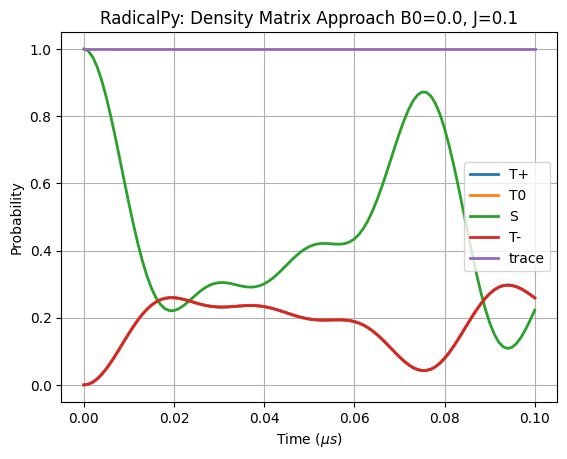

In [3]:
if has_rp_result := (is_small_case and len(sim.particles) < 7):
    # when D is Float, a bug appears
    assert isinstance(D, np.ndarray)
    H = sim.total_hamiltonian(
        B0=B0, D=D, J=J
    )  # , theta=np.arccos(1/np.sqrt(3)), phi=np.pi/4)
    time = np.arange(0, 1.0e-7 + 1e-09, 1e-09)
    kinetics = [
        rp.kinetics.Haberkorn(kS, rp.simulation.State.SINGLET),
        rp.kinetics.Haberkorn(kT, rp.simulation.State.TRIPLET),
    ]
    sim.apply_liouville_hamiltonian_modifiers(H, kinetics)
    rhos = sim.time_evolution(State.SINGLET, time, H)

    time_evol_s = sim.product_probability(State.SINGLET, rhos)
    time_evol_tp = sim.product_probability(State.TRIPLET_PLUS, rhos)
    time_evol_tz = sim.product_probability(State.TRIPLET_ZERO, rhos)
    time_evol_tm = sim.product_probability(State.TRIPLET_MINUS, rhos)
    x = time * 1e6

    plt.plot(x, time_evol_tp, linewidth=2, label="T+")
    plt.plot(x, time_evol_tz, linewidth=2, label="T0")
    plt.plot(x, time_evol_s, linewidth=2, label="S")
    plt.plot(x, time_evol_tm, linewidth=2, label="T-")
    plt.plot(
        x,
        time_evol_tp + time_evol_tz + time_evol_s + time_evol_tm,
        linewidth=2,
        label="trace",
    )
    plt.legend()
    plt.title(f"RadicalPy: Density Matrix Approach {B0=}, {J=}")
    plt.xlabel(r"Time ($\mu s$)")
    plt.ylabel("Probability")
    # plt.ylim([0, 1])
    plt.grid()
    plt.show()

In [4]:
input_path, output_path = dump_input(
    sim=sim,
    output_folder="out",
    simulation_type="exact_dynamics",  # "exact_dynamics", "trace_sampling"
    J=J,
    D=D,
    kS=kS,
    kT=kT,
    B=B0,
    dt=5e-10,
    simulation_time=1e-07 - 5e-10,
    N_krylov=10,
    integrator_tolerance=1e-08,
    N_samples=512,
    M1=1,
    M2=2,
)
print(input_path)
# cat contents of input file
with open(input_path) as f:
    print(f.read())

remove output folder
create output folder /home/hinom/GitHub/Spin_dynamics/example/out
/home/hinom/GitHub/Spin_dynamics/example/input.ini
[system variables]
J = 0.1
D = -0.0 0.0 0.0 0.0 -0.0 0.0 0.0 0.0 0.0
kS = 0.0
kT = 0.0
[electron 1]
g = 2.0023193
I = 2
N_I = 1
A1 = 0.5 0.0 0.0 0.0 0.5 0.0 0.0 0.0 0.5
[electron 2]
g = 2.0023193
I = 2 3
N_I = 1 1
A1 = 0.4 0.0 0.0 0.0 0.4 0.0 0.0 0.0 0.4
A2 = 0.5 0.0 0.0 0.0 0.5 0.0 0.0 0.0 0.5
[simulation parameters]
simulation_type = exact_dynamics
output_folder = out
seed = 42 99
B = 0.0
initial_state = singlet
simulation_time = 99.5
dt = 0.5
N_krylov = 10
integrator_tolerance = 1e-08



In [5]:
# Execute sphinchem
import subprocess

subprocess.run(["../bin/spinchem", input_path])

 Program initialised
           1
           2
  -0.0000000000000000       -0.0000000000000000        0.0000000000000000       0.10000000000000001        0.0000000000000000     
Time elapsed:   0: 0: 0


CompletedProcess(args=['../bin/spinchem', PosixPath('/home/hinom/GitHub/Spin_dynamics/example/input.ini')], returncode=0)

In [6]:
df = parse_output(output_path="out", subdir=".200", dt=5e-10)[:-1]

In [7]:
df

S_prob,Tm_prob,Tp_prob,T0_prob,time
f64,f64,f64,f64,f64
1.0,0.0,0.0,0.0,0.0
0.998726,0.0,0.000881,0.000392,0.0005
0.994913,0.0,0.00352,0.001567,0.001
0.988583,0.0,0.007899,0.003518,0.0015
0.979773,0.0,0.013992,0.006235,0.002
…,…,…,…,…
0.077539,0.0,0.595744,0.326717,0.0975
0.08184,0.0,0.590008,0.328152,0.098
0.087562,0.0,0.583261,0.329177,0.0985


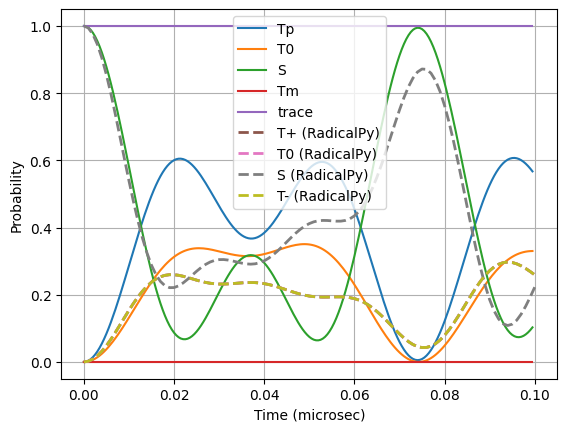

In [8]:
plt.plot(df["time"], df["Tp_prob"], label="Tp")
plt.plot(df["time"], df["T0_prob"], label="T0")
plt.plot(df["time"], df["S_prob"], label="S")
plt.plot(df["time"], df["Tm_prob"], label="Tm")
plt.plot(
    df["time"],
    df["S_prob"] + df["T0_prob"] + df["Tp_prob"] + df["Tm_prob"],
    label="trace",
)
if has_rp_result:
    plt.plot(x, time_evol_tp, linewidth=2, label="T+ (RadicalPy)", ls="--")
    plt.plot(x, time_evol_tz, linewidth=2, label="T0 (RadicalPy)", ls="--")
    plt.plot(x, time_evol_s, linewidth=2, label="S (RadicalPy)", ls="--")
    plt.plot(x, time_evol_tm, linewidth=2, label="T- (RadicalPy)", ls="--")
plt.xlabel("Time (microsec)")
plt.ylabel("Probability")
plt.grid()
plt.legend()
# plt.ylim(0.0, 0.001)
plt.show()